# Image Classification using Convolutional Neural Networks in PyTorch

## Exploring the CIFAR10 Dataset

For this tutorial, we'll use the CIFAR10 dataset, which consists of 60000 32x32 px colour images in 10 classes. Here are some sample images from the dataset:

<img src="https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png" style="max-width:480px">


In [2]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

We'll download the images in PNG format from [this page](https://course.fast.ai/datasets), using some helper functions from the `torchvision` and `tarfile` packages.

In [3]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

100%|██████████| 135107811/135107811 [01:02<00:00, 2170061.86it/s]


In [4]:
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

The dataset is extracted to the directory `data/cifar10`. It contains 2 folders `train` and `test`, containing the training set (50000 images) and test set (10000 images) respectively. Each of them contains 10 folders, one for each class of images. Let's verify this using `os.listdir`.

In [5]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['ship', 'frog', 'automobile', 'dog', 'cat', 'truck', 'deer', 'airplane', 'bird', 'horse']


Let's look inside a couple of folders, one from the training set and another from the test set. As an exercise, you can verify that that there are an equal number of images for each class, 5000 in the training set and 1000 in the test set.

In [6]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['4421.png', '4978.png', '3368.png', '4703.png', '3680.png']


In [7]:
ship_test_files = os.listdir(data_dir + "/test/ship")
print("No. of test examples for ship:", len(ship_test_files))
print(ship_test_files[:5])

No. of test examples for ship: 1000
['0470.png', '0126.png', '0690.png', '0158.png', '0263.png']


The above directory structure (one folder per class) is used by many computer vision datasets, and most deep learning libraries provide utilites for working with such datasets. We can use the `ImageFolder` class from `torchvision` to load the data as PyTorch tensors.

In [8]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [9]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

Let's look at a sample element from the training dataset. Each element is a tuple, containing a image tensor and a label. Since the data consists of 32x32 px color images with 3 channels (RGB), each image tensor has the shape `(3, 32, 32)`.

The list of classes is stored in the `.classes` property of the dataset. The numeric label for each element corresponds to index of the element's label in the list of classes.

In [11]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


We can view the image using `matplotlib`, but we need to change the tensor dimensions to `(32,32,3)`. Let's create a helper function to display an image and its label.

In [12]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [13]:

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Let's look at a couple of images from the dataset. As you can tell, the 32x32px images are quite difficult to identify, even for the human eye. Try changing the indices below to view different images.

Label:  airplane (0)


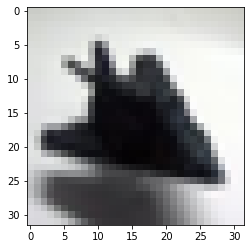

In [14]:
show_example(*dataset[0])

Label:  airplane (0)


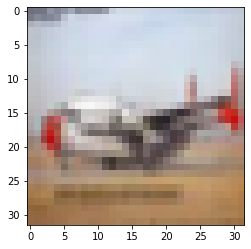

In [15]:
show_example(*dataset[1099])

## Training and Validation Datasets

While building real world machine learning models, it is quite common to split the dataset into 3 parts:

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

Since there's no predefined validation set, we can set aside a small portion (5000 images) of the training set to be used as the validation set. We'll use the `random_split` helper method from PyTorch to do this. To ensure that we always create the same validation set, we'll also set a seed for the random number generator.

In [16]:
random_seed = 42
torch.manual_seed(random_seed);

In [17]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

We can now create data loaders for training and validation, to load the data in batches

In [18]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [19]:
batch_size=128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

We can look at batches of images from the dataset using the `make_grid` method from `torchvision`. Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches.

## Defining the Model (Convolutional Neural Network)

For this tutorial, we will use a convolutional neural network, using the `nn.Conv2d` class from PyTorch.

> The 2D convolution is a fairly simple operation at heart: you start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel. - [Source](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)

<img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" style="max-width:400px;">


Let us implement a convolution operation on a 1 channel image with a 3x3 kernel.

For multi-channel images, a different kernel is applied to each channels, and the outputs are added together pixel-wise. 

Checking out the following articles to gain a better understanding of convolutions:

1. [Intuitively understanding Convolutions for Deep Learning](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1) by Irhum Shafkat
2. [Convolutions in Depth](https://sgugger.github.io/convolution-in-depth.html) by Sylvian Gugger (this article implements convolutions from scratch)

There are certain advantages offered by convolutional layers when working with image data:

* **Fewer parameters**: A small set of parameters (the kernel) is used to calculate outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer. 
* **Sparsity of connections**: In each layer, each output element only depends on a small number of input elements, which makes the forward and backward passes more efficient.
* **Parameter sharing and spatial invariance**: The features learned by a kernel in one part of the image can be used to detect similar pattern in a different part of another image.

We will also use a [max-pooling](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) layers to progressively decrease the height & width of the output tensors from each convolutional layer.

<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" style="max-width:400px;">

Before we define the entire model, let's look at how a single convolutional layer followed by a max-pooling layer operates on the data.

In [24]:
import torch.nn as nn
import torch.nn.functional as F

The `Conv2d` layer transforms a 3-channel image to a 16-channel *feature map*, and the `MaxPool2d` layer halves the height and width. The feature map gets smaller as we add more layers, until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get vector of size 10 for each image.

<img src="https://i.imgur.com/KKtPOKE.png" style="max-width:540px">

Let's define the model by extending an `ImageClassificationBase` class which contains helper methods for training & validation.

In [27]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


We'll use `nn.Sequential` to chain the layers and activations functions into a single network architecture.

In [28]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [29]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

Let's verify that the model produces the expected output on a batch of training data. The 10 outputs for each image can be interpreted as probabilities for the 10 target classes (after applying softmax), and the class with the highest probability is chosen as the label predicted by the model for the input image.

In [30]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0239, -0.0466,  0.0067,  0.0193,  0.0044, -0.0598, -0.0188, -0.0242,
         0.0431, -0.0164], grad_fn=<SelectBackward0>)


To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required. 

In [31]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [32]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available), and use `to_device` to move our model to the GPU (if available).

In [33]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

## Model Training Functions

We'll define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set. 

In [45]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accuracies = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Calculate accuracy
            output = model(batch[0])  # Assuming batch[0] is the input data
            acc = accuracy(output, batch[1])  # Assuming batch[1] are the labels
            train_accuracies.append(acc)

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracies).mean().item()  # Add train accuracy
        model.epoch_end(epoch, result)
        history.append(result)
    return history


Before we begin training, let's instantiate the model once again and see how it performs on the validation set with the initial set of parameters.

The initial accuracy is around 10%, which is what one might expect from a randomly intialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

We'll use the following *hyperparmeters* (learning rate, no. of epochs, batch_size etc.) to train our model. As an exercise, you can try changing these to see if you have achieve a higher accuracy in a shorter time. 

In [37]:
# !pip install lion-pytorch

In [38]:
class lion_optimizer(torch.optim.Optimizer): 

    def __init__(self, params, learning_rate = 1e-3, beta1 = 0.9, beta2 = 0.99, lambdaa = 0.01):
        super(lion_optimizer, self).__init__(params, defaults={'lr': learning_rate})
        self.state = dict()
        self.beta1 = beta1
        self.beta2 = beta2
        self.lambdaa = lambdaa
        for group in self.param_groups:
            for p in group['params']:
                self.state[p] = dict(momentum = torch.zeros_like(p.data))

    def step(self): 
        for group in self.param_groups:
            for p in group['params']:
                if p not in self.state: 
                    self.state[p] = dict(momentum = torch.zeros_like(p.data))
                m = self.beta1 * self.state[p]['momentum'] + (1 - self.beta1) * p.grad.data
                p.data -= group['lr'] * (torch.sign(m) + self.lambdaa * p.data)
                m = self.beta2 * self.state[p]['momentum'] + (1 - self.beta2) * p.grad.data
                self.state[p]['momentum'] = m

We can also plot the valdation set accuracies to study how the model improves over time.

# Batch Size Ablation

In [52]:
batch_sizes = [32, 64, 128, 256, 512, 1024, 2048, 4096]

In [53]:
from tqdm import tqdm
lion_batchSize_ablation_train_loss = {}
lion_batchSize_ablation_valid_loss = {}
lion_batchSize_ablation_train_accuracy = {}
lion_batchSize_ablation_valid_accuracy = {}

for batch_size in tqdm(batch_sizes):
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)
    train_dl = DeviceDataLoader(train_dl, device)
    val_dl = DeviceDataLoader(val_dl, device)
    to_device(model, device)

    num_epochs = 20
    opt_func = lion_optimizer
    lr = 1e-4
    model = to_device(Cifar10CnnModel(), device)
    history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

    lion_batchSize_ablation_train_loss[batch_size] = []
    lion_batchSize_ablation_valid_loss[batch_size] = []
    lion_batchSize_ablation_train_accuracy[batch_size] = []
    lion_batchSize_ablation_valid_accuracy[batch_size] = []

    for epoch_history in history:
        lion_batchSize_ablation_train_loss[batch_size].append(epoch_history['train_loss'])
        lion_batchSize_ablation_valid_loss[batch_size].append(epoch_history['val_loss'])
        lion_batchSize_ablation_train_accuracy[batch_size].append(epoch_history['train_acc'])
        lion_batchSize_ablation_valid_accuracy[batch_size].append(epoch_history['val_acc'])

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.6292, val_loss: 1.2310, val_acc: 0.5410
Epoch [1], train_loss: 1.0575, val_loss: 0.9178, val_acc: 0.6722
Epoch [2], train_loss: 0.8067, val_loss: 0.7562, val_acc: 0.7387
Epoch [3], train_loss: 0.6427, val_loss: 0.7178, val_acc: 0.7550
Epoch [4], train_loss: 0.5224, val_loss: 0.6625, val_acc: 0.7769
Epoch [5], train_loss: 0.4243, val_loss: 0.6594, val_acc: 0.7876
Epoch [6], train_loss: 0.4111, val_loss: 0.7067, val_acc: 0.7783
Epoch [7], train_loss: 0.3783, val_loss: 0.6995, val_acc: 0.7864
Epoch [8], train_loss: 0.2763, val_loss: 0.7565, val_acc: 0.7818
Epoch [9], train_loss: 0.2778, val_loss: 0.8174, val_acc: 0.7797
Epoch [10], train_loss: 0.2135, val_loss: 0.9186, val_acc: 0.7743
Epoch [11], train_loss: 0.1837, val_loss: 0.9897, val_acc: 0.7753
Epoch [12], train_loss: 0.1866, val_loss: 0.9872, val_acc: 0.7735
Epoch [13], train_loss: 0.1606, val_loss: 1.0439, val_acc: 0.7783
Epoch [14], train_loss: 0.3093, val_loss: 0.9582, val_acc: 0.7633
Epoch [15], train_lo

 12%|█▎        | 1/8 [06:29<45:28, 389.83s/it]

Epoch [19], train_loss: 0.1304, val_loss: 1.1106, val_acc: 0.7771
Epoch [0], train_loss: 1.7786, val_loss: 1.4719, val_acc: 0.4591
Epoch [1], train_loss: 1.2571, val_loss: 1.1063, val_acc: 0.6068
Epoch [2], train_loss: 0.9694, val_loss: 0.9213, val_acc: 0.6768
Epoch [3], train_loss: 0.7683, val_loss: 0.7753, val_acc: 0.7334
Epoch [4], train_loss: 0.6209, val_loss: 0.6832, val_acc: 0.7654
Epoch [5], train_loss: 0.5050, val_loss: 0.6950, val_acc: 0.7712
Epoch [6], train_loss: 0.4054, val_loss: 0.6536, val_acc: 0.7840
Epoch [7], train_loss: 0.3176, val_loss: 0.6739, val_acc: 0.7903
Epoch [8], train_loss: 0.2455, val_loss: 0.7058, val_acc: 0.7864
Epoch [9], train_loss: 0.1950, val_loss: 0.8031, val_acc: 0.7937
Epoch [10], train_loss: 0.1609, val_loss: 0.8324, val_acc: 0.7963
Epoch [11], train_loss: 0.1488, val_loss: 0.8629, val_acc: 0.7933
Epoch [12], train_loss: 0.1309, val_loss: 0.8668, val_acc: 0.7814
Epoch [13], train_loss: 0.1199, val_loss: 1.0127, val_acc: 0.7896
Epoch [14], train_lo

 25%|██▌       | 2/8 [11:54<35:10, 351.78s/it]

Epoch [19], train_loss: 0.1716, val_loss: 0.9317, val_acc: 0.7795
Epoch [0], train_loss: 1.9138, val_loss: 1.6042, val_acc: 0.4018
Epoch [1], train_loss: 1.4437, val_loss: 1.2855, val_acc: 0.5271
Epoch [2], train_loss: 1.1624, val_loss: 1.0666, val_acc: 0.6129
Epoch [3], train_loss: 0.9622, val_loss: 0.9000, val_acc: 0.6873
Epoch [4], train_loss: 0.7944, val_loss: 0.7843, val_acc: 0.7213
Epoch [5], train_loss: 0.6579, val_loss: 0.7497, val_acc: 0.7420
Epoch [6], train_loss: 0.5389, val_loss: 0.6774, val_acc: 0.7645
Epoch [7], train_loss: 0.4274, val_loss: 0.6593, val_acc: 0.7811
Epoch [8], train_loss: 0.3254, val_loss: 0.6943, val_acc: 0.7844
Epoch [9], train_loss: 0.2384, val_loss: 0.7495, val_acc: 0.7904
Epoch [10], train_loss: 0.1741, val_loss: 0.7953, val_acc: 0.7912
Epoch [11], train_loss: 0.1320, val_loss: 0.8875, val_acc: 0.7930
Epoch [12], train_loss: 0.1115, val_loss: 0.9461, val_acc: 0.7877
Epoch [13], train_loss: 0.1012, val_loss: 0.9578, val_acc: 0.7869
Epoch [14], train_lo

 38%|███▊      | 3/8 [16:26<26:15, 315.08s/it]

Epoch [19], train_loss: 0.0702, val_loss: 1.0569, val_acc: 0.7939
Epoch [0], train_loss: 2.0828, val_loss: 1.9135, val_acc: 0.2983
Epoch [1], train_loss: 1.7441, val_loss: 1.6095, val_acc: 0.4028
Epoch [2], train_loss: 1.4981, val_loss: 1.4184, val_acc: 0.4820
Epoch [3], train_loss: 1.3232, val_loss: 1.2567, val_acc: 0.5430
Epoch [4], train_loss: 1.1656, val_loss: 1.1125, val_acc: 0.5961
Epoch [5], train_loss: 1.0247, val_loss: 1.0301, val_acc: 0.6277
Epoch [6], train_loss: 0.9041, val_loss: 0.9058, val_acc: 0.6751
Epoch [7], train_loss: 0.7906, val_loss: 0.8296, val_acc: 0.7051
Epoch [8], train_loss: 0.6837, val_loss: 0.7772, val_acc: 0.7234
Epoch [9], train_loss: 0.5917, val_loss: 0.7505, val_acc: 0.7460
Epoch [10], train_loss: 0.5062, val_loss: 0.6963, val_acc: 0.7614
Epoch [11], train_loss: 0.4252, val_loss: 0.7392, val_acc: 0.7679
Epoch [12], train_loss: 0.3433, val_loss: 0.7619, val_acc: 0.7624
Epoch [13], train_loss: 0.2718, val_loss: 0.7521, val_acc: 0.7796
Epoch [14], train_lo

 50%|█████     | 4/8 [20:52<19:42, 295.69s/it]

Epoch [19], train_loss: 0.0745, val_loss: 1.1977, val_acc: 0.7772
Epoch [0], train_loss: 2.1779, val_loss: 2.0487, val_acc: 0.2433
Epoch [1], train_loss: 1.9793, val_loss: 1.9199, val_acc: 0.2923
Epoch [2], train_loss: 1.8254, val_loss: 1.7603, val_acc: 0.3479
Epoch [3], train_loss: 1.6625, val_loss: 1.6169, val_acc: 0.4016
Epoch [4], train_loss: 1.5392, val_loss: 1.4939, val_acc: 0.4563
Epoch [5], train_loss: 1.4415, val_loss: 1.4317, val_acc: 0.4806
Epoch [6], train_loss: 1.3553, val_loss: 1.3224, val_acc: 0.5175
Epoch [7], train_loss: 1.2759, val_loss: 1.2727, val_acc: 0.5399
Epoch [8], train_loss: 1.1953, val_loss: 1.1849, val_acc: 0.5683
Epoch [9], train_loss: 1.1163, val_loss: 1.1128, val_acc: 0.6018
Epoch [10], train_loss: 1.0438, val_loss: 1.0621, val_acc: 0.6204
Epoch [11], train_loss: 0.9735, val_loss: 1.0334, val_acc: 0.6306
Epoch [12], train_loss: 0.9072, val_loss: 0.9691, val_acc: 0.6549
Epoch [13], train_loss: 0.8460, val_loss: 0.9284, val_acc: 0.6704
Epoch [14], train_lo

 62%|██████▎   | 5/8 [24:37<13:30, 270.20s/it]

Epoch [19], train_loss: 0.4973, val_loss: 0.7916, val_acc: 0.7380
Epoch [0], train_loss: 2.2391, val_loss: 2.1391, val_acc: 0.2177
Epoch [1], train_loss: 2.0691, val_loss: 2.0274, val_acc: 0.2464
Epoch [2], train_loss: 1.9571, val_loss: 1.9102, val_acc: 0.3057
Epoch [3], train_loss: 1.8591, val_loss: 1.8186, val_acc: 0.3326
Epoch [4], train_loss: 1.7661, val_loss: 1.7406, val_acc: 0.3563
Epoch [5], train_loss: 1.6802, val_loss: 1.6546, val_acc: 0.3845
Epoch [6], train_loss: 1.6046, val_loss: 1.5897, val_acc: 0.4161
Epoch [7], train_loss: 1.5396, val_loss: 1.5290, val_acc: 0.4334
Epoch [8], train_loss: 1.4827, val_loss: 1.4730, val_acc: 0.4569
Epoch [9], train_loss: 1.4257, val_loss: 1.4224, val_acc: 0.4782
Epoch [10], train_loss: 1.3760, val_loss: 1.3647, val_acc: 0.4952
Epoch [11], train_loss: 1.3273, val_loss: 1.3239, val_acc: 0.5111
Epoch [12], train_loss: 1.2768, val_loss: 1.2645, val_acc: 0.5404
Epoch [13], train_loss: 1.2234, val_loss: 1.2346, val_acc: 0.5445
Epoch [14], train_lo

 75%|███████▌  | 6/8 [28:21<08:28, 254.42s/it]

Epoch [19], train_loss: 0.9571, val_loss: 1.0177, val_acc: 0.6364
Epoch [0], train_loss: 2.2914, val_loss: 2.2445, val_acc: 0.1582


 75%|███████▌  | 6/8 [28:35<09:31, 285.90s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 7.77 GiB total capacity; 3.64 GiB already allocated; 565.94 MiB free; 5.98 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [54]:
history

[{'val_loss': 2.139134407043457,
  'val_acc': 0.21773886680603027,
  'train_loss': 2.239062786102295,
  'train_acc': 0.15807069838047028},
 {'val_loss': 2.0273900032043457,
  'val_acc': 0.2463962286710739,
  'train_loss': 2.069089412689209,
  'train_acc': 0.23685401678085327},
 {'val_loss': 1.9102083444595337,
  'val_acc': 0.3056986331939697,
  'train_loss': 1.9571280479431152,
  'train_acc': 0.28979089856147766},
 {'val_loss': 1.8185739517211914,
  'val_acc': 0.33256879448890686,
  'train_loss': 1.8590906858444214,
  'train_acc': 0.32587289810180664},
 {'val_loss': 1.7406208515167236,
  'val_acc': 0.3563312292098999,
  'train_loss': 1.7660993337631226,
  'train_acc': 0.3532344102859497},
 {'val_loss': 1.6545885801315308,
  'val_acc': 0.38448041677474976,
  'train_loss': 1.680193305015564,
  'train_acc': 0.3809789717197418},
 {'val_loss': 1.589747667312622,
  'val_acc': 0.4161055088043213,
  'train_loss': 1.6045799255371094,
  'train_acc': 0.4078269302845001},
 {'val_loss': 1.529028773

# Saving Results

In [55]:
import json

# Save the dictionary to a file
with open('lion_modelArchirecture_ablation_train_loss.json', 'w') as file:
    json.dump(lion_batchSize_ablation_train_loss, file)


# Save the dictionary to a file
with open('lion_batchSize_ablation_valid_loss.json', 'w') as file:
    json.dump(lion_batchSize_ablation_valid_loss, file)


# Save the dictionary to a file
with open('lion_batchSize_ablation_train_accuracy.json', 'w') as file:
    json.dump(lion_batchSize_ablation_train_accuracy, file)


# Save the dictionary to a file
with open('lion_batchSize_ablation_valid_accuracy.json', 'w') as file:
    json.dump(lion_batchSize_ablation_valid_accuracy, file)
